# Waze User Churn - 03. Feature Engineering & Modeling

**Project Goal:** To analyze user churn behavior and build a model to predict it.

**Notebook 3 Goal:** In this notebook, I will build and compare several models to predict user churn. I will:
1.  **Feature Engineering:** Create new features from the cleaned data (`waze_clean.csv`) to better capture user behavior.
2.  **Data Split:** Divide the data into three sets: Train, Validation, and Test (60/20/20 split). This is a robust method to prevent overfitting.
3.  **Preprocessing:** Create separate data pipelines for different model types (e.g., scaled data for Neural Network, SVM, unscaled for Tree models).
4.  **Model Building & Tuning:** Train and tune (using `GridSearchCV`) and evaluate five models: Neural Network (MLPClassifier), Support Vector Machine (SVM), Decision Tree Classifier, Random Forest Classifier, and XGBoost.
5.  **Model Selection:** Compare the models' performance on the **Validation Set** using **Recall** as my primary business metric.
6.  **Final Evaluation:** Report the final, unbiased performance of the *champion model* on the **Test Set**.
7. **Business Goal - Threshold Tuning:** Identify an optimal decision threshold for the champion model to maximize **Recall**, aligning the model's output with our specific business objective of finding the most at-risk users.

### Business Metric: Recall

For this business problem, **Recall is the most important metric**. I want to identify as many *actual* churners as possible (minimize False Negatives). 

It is less costly to send a retention offer to a user who *wasn't* going to churn (False Positive) than it is to *miss* a user who *was* going to churn (False Negative).

## 1. Import Libraries and Load Data

In [1]:
# import libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# import sklearn libraries for model building 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# import sklearn metrics for model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    roc_auc_score, roc_curve
)
from sklearn.inspection import permutation_importance

# set options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [2]:
# load the cleaned data
df = pd.read_csv('../data/processed/waze_clean.csv')
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,retained,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,retained,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,iPhone
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


## Step 2: Feature Engineering

In this step, I will create new features from the cleaned data. The goal of feature engineering is to transform raw data into features that better represent the underlying problem and provide stronger signals for my machine learning models. 

Many of these features are based on insights from my EDA in Notebook 01 or standard practices for churn modeling (e.g., creating ratios, normalizing by time).

In [3]:
# create a copy for feature engineering to keep the cleaned data separate
df_fe = df.copy()

### 2.1. Create `percent_sessions_in_last_month`

**Why this feature?**

The raw data has `sessions` (last month) and `total_sessions` (lifetime). A simple count of `sessions` is misleading. 

* *User A:* 50 sessions last month / 1000 total sessions = 5% engagement
* *User B:* 50 sessions last month / 100 total sessions = 50% engagement

User B is far more engaged *recently*. This ratio captures the **recency and intensity of engagement**, which is a powerful predictor for churn. A low ratio might indicate a user is "fading away".

In [4]:
# crate new feature: percent_sessions_in_last_month
df_fe['percent_sessions_in_last_month'] = df_fe['sessions'] / df_fe['total_sessions']

### 2.2. Create `professional_driver`

**Why this feature?**

From the EDA, can saw that some users have a very high number of drives. Can hypothesize that "power users" (like commuters or professional drivers) behave differently than casual users. 

I will create a binary flag (based on the definition: `>= 60` drives **and** `>= 15` driving days in the last month) to capture this specific user segment. This allows the model to learn if this "power user" segment has a different churn propensity.

In [5]:
# create new feature: professional_driver
df_fe['professional_driver'] = np.where(
    (df_fe['drives'] >= 60) & (df_fe['driving_days'] >= 15),
    1,  # 1 for 'professional'
    0   # 0 for 'casual'
)

### 2.3. Create `total_sessions_per_day`

**Why this feature?**

`total_sessions` alone doesn't account for user tenure. A user with 1000 sessions over 5 years is less engaged than a user with 1000 sessions over 6 months. 

By dividing by `n_days_after_onboarding`, I create a **normalized, long-term engagement rate** (average sessions per day). This helps compare user engagement fairly, regardless of how long they've been on the platform.

In [6]:
# create new feature: total_sessions_per_day
df_fe['total_sessions_per_day'] = df_fe['total_sessions'] / df_fe['n_days_after_onboarding']

### 2.4. Create `km_per_driving_day`

**Why this feature?**

This was one of **strongest insights from the EDA** in Notebook 01. Can saw a clear positive correlation between the average kilometers a user drives *per day they are active* and their likelihood to churn.

This feature normalizes total distance by *frequency* (`driving_days`). A user driving 1000km in 2 days (500 km/day) is very different from a user driving 1000km in 20 days (50 km/day). This feature explicitly captures that high-intensity, long-distance behavior which our EDA flagged as a high-risk signal.

In [7]:
# create new feature: km_per_driving_daY
df_fe['km_per_driving_day'] = df_fe['driven_km_drives'] / df_fe['driving_days']

### 2.5. Create `km_per_drive`

**Why this feature?**

This normalizes total distance by the number of individual drives. It helps capture the *nature* of the user's trips. 

* *User A:* 100km / 1 drive = 100 km/drive (Long-haul user)
* *User B:* 100km / 10 drives = 10 km/drive (Short-trip user)

The EDA in Notebook 01 (using `km_per_driving_day`) already suggested that users who drive longer distances are more likely to churn. This feature provides a similar signal.

In [8]:
# create new feature: km_per_drive
df_fe['km_per_drive'] = df_fe['driven_km_drives'] / df_fe['drives']

### 2.6. Create `km_per_hour`

**Why this feature?**

This feature is a proxy for the user's average driving *speed*. 

* A **high** `km_per_hour` value likely indicates highway or long-distance, clear-road driving.
* A **low** `km_per_hour` value likely indicates city, stop-and-go, or traffic-heavy driving.

Since the EDA (and the `km_per_driving_day` feature) suggests that long-distance users are more likely to churn, this feature gives the model another strong signal to identify this specific user profile.

In [9]:
# create new feature: km_per_hour
df_fe['km_per_hour'] = df_fe['driven_km_drives'] / (df_fe['duration_minutes_drives'] / 60)

### 2.7. Create `percent_of_drives_to_favorite`

**Why this feature?**

This is a proxy for user "stickiness" or "investment" in the Waze platform. Users who take the time to save "Home" and "Work" (or other favorites) and navigate to them are likely more integrated into the app's ecosystem. 

A high percentage of drives to favorites suggests a habitual, loyal user, while a low percentage suggests a casual user who is less "sticky" and thus more likely to churn.

In [10]:
# create new feature: percent_of_drives_to_favorite
df_fe['percent_of_drives_to_favorite'] = (
    df_fe['total_navigations_fav1'] + df_fe['total_navigations_fav2']
) / df_fe['total_sessions']

### 2.8. Handle Division by Zero

Finally, there are several of our new ratio-based features (`km_per_driving_day`, `km_per_hour`, `km_per_drive`, etc.) might have resulted in `inf` (infinity) values if their denominator was 0 (e.g., `driving_days = 0` or `drives = 0`). These `inf` values will break our machine learning models. Must replace them with a neutral value, like 0.

In [11]:
# check for infinity values before replacing
print("Original infinity counts:")
print(df_fe.isin([np.inf, -np.inf]).sum())

# replace all infinite values in the dataframe with 0
df_fe.replace([np.inf, -np.inf], 0, inplace=True)

print("\nInfinity values replaced with 0.")

Original infinity counts:
label                               0
sessions                            0
drives                              0
total_sessions                      0
n_days_after_onboarding             0
total_navigations_fav1              0
total_navigations_fav2              0
driven_km_drives                    0
duration_minutes_drives             0
activity_days                       0
driving_days                        0
device                              0
percent_sessions_in_last_month      0
professional_driver                 0
total_sessions_per_day              0
km_per_driving_day                983
km_per_drive                      102
km_per_hour                         0
percent_of_drives_to_favorite       0
dtype: int64

Infinity values replaced with 0.


### 2.10. Final Check on Engineered Features

Now, I will review the final dataframe with all new features before moving to the modeling phase.

In [12]:
# check missing values after feature engineering
print("\nCheck again for missing values after feature engineering:")
print(df_fe.isnull().sum())

# display the dataframe to check all new columns
print("\nDataframe with all new features:")
df_fe.head()



Check again for missing values after feature engineering:
label                             0
sessions                          0
drives                            0
total_sessions                    0
n_days_after_onboarding           0
total_navigations_fav1            0
total_navigations_fav2            0
driven_km_drives                  0
duration_minutes_drives           0
activity_days                     0
driving_days                      0
device                            0
percent_sessions_in_last_month    0
professional_driver               0
total_sessions_per_day            0
km_per_driving_day                0
km_per_drive                      0
km_per_hour                       0
percent_of_drives_to_favorite     0
dtype: int64

Dataframe with all new features:


,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_driving_day,km_per_drive,km_per_hour,percent_of_drives_to_favorite
0,retained,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,0.818876,1,0.130381,138.360267,13.144225,79.430298,0.700931
1,retained,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,iPhone,0.406856,0,0.266854,808.974207,83.165573,168.937685,0.253903
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,0.841186,0,0.051121,382.393602,32.201567,113.953460,0.000000
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,0.724968,0,4.505948,304.530374,22.839778,93.351141,4.867640
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,0.499266,1,0.107713,219.455667,58.091206,194.342970,1.016363


## 3. Define Target Features and Split Data

Now, I will first define feature matrix (`X`) and target vector (`y`).

Immediately after, I will split the data into **Train, Validation, and Test** sets. This split is performed *before* any preprocessing (like scaling or target encoding) to prevent data leakage.

### 3.1. Define Feature Matrix (X) and Target Vector (y)

I will set `y` as target variable (`label`). 

For `X`, I will drop the original `label` and `device` columns. I will also drop `sessions` and `driving_days`, based on the **high multicollinearity (0.99 and 0.95)** discovered in EDA (Notebook 01). This is essential for our Logistic Regression model and is good practice for tree models as well.

In [13]:
# define target variable
y = df_fe['label']

# define feature matrix (X)
X = df_fe.drop(columns=[
    'label', 
    'device', 
    'sessions',       # drop due to high correlation (0.99) with 'drives'
    'driving_days'    # drop due to high correlation (0.95) with 'activity_days'
])

# verify the shapes of X and y
print(f"Feature matrix (X) shape: {X.shape}")
print(f"Target vector (y) shape: {y.shape}")
print("\nFirst 5 rows of X:")
display(X.head())

Feature matrix (X) shape: (14299, 15)
Target vector (y) shape: (14299,)

First 5 rows of X:


,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_driving_day,km_per_drive,km_per_hour,percent_of_drives_to_favorite
0,200,296.748273,2276,208,0,2628.845068,1985.775061,28,0.818876,1,0.130381,138.360267,13.144225,79.430298,0.700931
1,107,326.896596,1225,19,64,8898.716275,3160.472914,13,0.406856,0,0.266854,808.974207,83.165573,168.937685,0.253903
2,95,135.522926,2651,0,0,3059.148818,1610.735904,14,0.841186,0,0.051121,382.393602,32.201567,113.953460,0.000000
3,40,67.589221,15,322,7,913.591123,587.196542,7,0.724968,0,4.505948,304.530374,22.839778,93.351141,4.867640
4,68,168.247020,1562,166,5,3950.202008,1219.555924,27,0.499266,1,0.107713,219.455667,58.091206,194.342970,1.016363


### 3.2. Create Train-Validation-Test Split

I will use a 60% Train / 20% Validation / 20% Test split.

* **Train Set (60%):** Used to train the models.
* **Validation Set (20%):** Used to tune hyperparameters and select the "champion" model.
* **Test Set (20%):** Kept separate until the very end to get an unbiased performance score.

Use `stratify=y` to ensure the 17.7% churn rate is preserved in all three splits.

In [14]:
# split into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.25, # 0.25 * 0.80 = 0.20
    random_state=42, 
    stratify=y_train_full
)

# verify the shapes of the splits
print(f"Train set:    X={X_train.shape}, y={y_train.shape}")
print(f"Valid set:    X={X_val.shape},   y={y_val.shape}")
print(f"Test set:     X={X_test.shape},  y={y_test.shape}")

Train set:    X=(8579, 15), y=(8579,)
Valid set:    X=(2860, 15),   y=(2860,)
Test set:     X=(2860, 15),  y=(2860,)


## 4. Preprocessing for Modeling

Now that the data is split, I will create two separate sets of feature matrices (`X`) for our different model types:

1. **For Tree-Based Models (Decision Tree, RF, XGBoost):** I will use the data as-is (unscaled). These models are not sensitive to feature scales

2. **For Scaled-Data Models (MLP, SVM):** I must scale numeric features. These models are sensitive to feature scales, scaling ensures all features contribute fairly to the model's coefficients.

First, I will encode the target variable `y` (which is still categorical) into numbers.

### 4.1. Target Encoding (y)

Need to convert the `y` splits from categorical ('retained', 'churned') to numeric (0, 1) so models can process them.

In [15]:
# encode target variable
y_train = y_train.map({'retained': 0, 'churned': 1})
y_val = y_val.map({'retained': 0, 'churned': 1})
y_test = y_test.map({'retained': 0, 'churned': 1})

# verify the first 5 values of y_train after encoding
print(f"y_train first 5 values:\n{y_train.head()}")

y_train first 5 values:
5385     0
2432     1
2990     0
4193     0
11060    0
Name: label, dtype: int64


### 4.2. Preprocessing for Scaled-Data Models (MLP, SVM)

Here, I will scale the numeric features. I will **fit** the `StandardScaler` **only** on the `X_train` data to prevent **data leakage**, and then use that *same* fitted scaler to **transform** `X_val` and `X_test`.

In [16]:
# identify all numeric columns 
numeric_cols = X_train.columns

# initialize the StandardScaler
scaler = StandardScaler()

# fit the scaler on the training data only
scaler.fit(X_train[numeric_cols])

# transform all three splits
X_train_scaled = scaler.transform(X_train[numeric_cols])
X_val_scaled = scaler.transform(X_val[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

# verify the the first 5 rows of the scaled training data
X_train_scaled[:5]

array([[ 2.44125396,  1.7293006 , -1.36916805, -0.11845213, -0.65635147,
         2.23924493, -0.92002783,  0.71293349,  0.63439781,  2.1515727 ,
         0.56947603, -0.14723295, -0.31336723,  2.30723822, -0.33667897],
       [-0.55469409, -0.68206089, -1.55581946,  0.10562744,  0.25266876,
         1.56990789,  1.53749297, -0.95135397, -0.1828644 , -0.4647763 ,
         0.17720899,  0.51248444, -0.00721216, -0.25130548,  0.03522679],
       [-0.84346016, -1.17579307,  1.63115416,  0.78465642, -0.65635147,
         1.41556133,  0.5862052 , -0.61849648,  0.16157463, -0.4647763 ,
        -0.24765286,  0.63667386,  0.30120684, -0.06849446,  0.94157435],
       [-0.86150804, -0.84797961,  0.45564738, -0.82464228,  0.23102542,
        -0.11510062,  0.14570892, -0.61849648, -0.88042588, -0.4647763 ,
        -0.22786899, -0.10818806, -0.00907717, -0.28600754, -0.27997009],
       [-1.02393896, -1.28739763, -0.01892377, -0.65488503, -0.43991808,
         0.51440237,  1.1294043 , -1.06230646, 

### 4.3. Preprocessing for Tree-Based Models (DT, RF, XGB)

Tree-based models do not require feature scaling. I can use the data directly as it is. For clarity in our code, I'll assign them to new variable names.

In [17]:
# data for tree models is the original (unscaled) data
X_train_tree = X_train
X_val_tree = X_val
X_test_tree = X_test

# verify the the first 5 rows of the scaled training data
X_train_tree[:5]

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_driving_day,km_per_drive,km_per_hour,percent_of_drives_to_favorite
5385,200,389.805616,379,104,0,8898.716275,675.698730,22,0.623388,1,1.028511,423.748394,44.493581,790.179044,0.266800
2432,34,103.345741,191,137,42,7418.202541,3672.999333,7,0.396727,0,0.541077,1059.743220,218.182428,121.179481,1.732050
2990,18,44.692379,3401,237,0,7076.801720,2512.766868,10,0.492254,0,0.013141,1179.466953,393.155651,168.980302,5.302917
4193,17,83.635276,2217,0,41,3691.114221,1975.518213,10,0.203264,0,0.037725,461.389278,217.124366,112.105701,0.490224
11060,8,31.434214,1739,25,10,5083.518608,3175.276418,6,0.286312,0,0.018076,847.253101,635.439826,96.058130,1.113436


## 5. Model Building, Tuning, and Evaluation

Now I will train all models on the **Train Set** (`X_train...`) and compare their performance on the **Validation Set** (`X_val...`).

My primary evaluation metric is **RECALL** for the `churned` class (class `1`), as the business goal is to identify as many potential churners as possible (minimizing False Negatives).

The models selected for predicting Waze user churn include:

1.  **Neural Network (MLPClassifier)**
2.  **Support Vector Machine (SVM)**
3.  **Decision Tree Classifier**
4.  **Random Forest Classifier**
5.  **XGBoost**

A critical consideration, which identified in my EDA (Notebook 01), is the **imbalanced nature** of the target variable (`y`), which has only 17.7% 'churned' samples.

**Why this is a problem:** By default, most machine learning models are optimized for **accuracy**. They will quickly learn that they can be over 82% accurate by simply predicting the majority class ('retained') for everyone. This would result in a model with excellent accuracy but a **Recall** of nearly zero for the 'churned' class, completely failing this business goal.

**Solution (Handling Imbalance):** To combat this, I will explicitly instruct *all* models to handle this imbalance during training. This forces the models to place a higher penalty on misclassifying the rare 'churn' class.
* For Scikit-learn models (MLP, SVM, Decision Tree, Random Forest), I will include `class_weight='balanced'` in the hyperparameter grid.
* For XGBoost, I will use its equivalent parameter, `scale_pos_weight`.

This strategy is essential to ensure `GridSearchCV` (which is optimizing for `recall`) can find models that effectively identify the minority 'churn' class, rather than just ignoring it.

### 5.1. Model building & Hyperparameter tuning

I will use **GridSearchCV** to tune the hyperparameters of each model. This is a technique for tuning hyperparameters of machine learning models by exhaustively searching through a specified parameter grid. It combines **K-Fold Cross-Validation**, which splits the data into K subsets for **training and validation**, ensuring robust performance evaluation. 

In [18]:
# calculate scale_pos_weight for XGBoost (to handle class imbalance)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculated XGBoost scale_pos_weight: {scale_pos_weight:.2f}")

Calculated XGBoost scale_pos_weight: 4.64


In [ ]:
# define all models and their hyperparameter grids
models_with_params = {
    'Neural Network': {
        'model': MLPClassifier(max_iter=1000, random_state=42, early_stopping=True), 
        'params': {
            'hidden_layer_sizes': [(64, 32), (150,), (100, 50,)],     # 1 or 2 hidden layers
            'learning_rate_init': [0.001, 0.01, 0.1],                 # initial learning rate for weight updates
            'activation': ['logistic', 'relu'],                       # activation functions
            'solver': ['sgd', 'adam'],                                # optimization algorithms
            'alpha': [0.0001, 0.001, 0.01, 0.1],                      # regularization strength
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'kernel': ['linear', 'rbf'],                            # kernel functions
            'C': [0.1, 1, 10],                                      # regularization parameter
            'gamma': ['scale', 0.1, 0.01],                          # kernel coefficient for 'rbf'
            'class_weight': ['balanced'],                           # class weight to handle imbalance
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42), 
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 15, 20, None],                     # maximum depth of the tree
            'min_samples_split': [2, 10, 20],                       # minimum samples required to split a node
            'min_samples_leaf': [1, 5, 10],                         # minimum samples required at a leaf
            'class_weight': ['balanced'],                           # class weight to handle imbalance
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42), 
        'params': {
            'n_estimators': [100, 300, 500],                        # number of trees in the forest
            'max_depth': [10, 15, 20, None],                        # maximum depth of each tree
            'min_samples_split': [2, 10],                           # minimum samples required to split a node
            'min_samples_leaf': [1, 5],                             # minimum samples required at a leaf
            'class_weight': ['balanced'],                           # class weight to handle imbalance
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42), 
        'params': {
            'n_estimators': [100, 200, 300, 500],                   # number of boosting rounds / trees
            'max_depth': [3, 5, 7],                                 # maximum tree depth for base learners
            'learning_rate': [0.01, 0.05, 0.1],                     # shrinkage factor (eta) applied to each boosting step
            'gamma': [0, 0.1, 1],                                   # minimum loss reduction required for split
            'scale_pos_weight': [scale_pos_weight]                  # weight for positive class to address class imbalance
        }
    }
}

In [20]:
# define scoring metrics
scoring_metrics = {
    'recall': 'recall',
    'accuracy': 'accuracy'
}

# model that require scaled data
scaled_models = {'Neural Network', 'SVM'}

# storage for results
results = []
best_params_dict = {}

In [21]:
# loop through each model for training and hyperparameter tuning
for model_name, config in models_with_params.items():
    print(f"\n========== Training {model_name} ==========")

    # select appropriate data for each model
    X_train_data = X_train_scaled if model_name in scaled_models else X_train_tree

    # declare GridSearchCV
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        scoring=scoring_metrics,   # multiple metrics
        refit='recall',            # select best model based on recall
        cv=4,                      # 4-fold cross-validation
        n_jobs=-1,                 # utilize all CPU cores
        verbose=1                  # print progress messages
    )

    # train + cross-validation
    grid_search.fit(X_train_data, y_train)

    # get index of best parameters based on recall
    best_idx = grid_search.best_index_
    cv_results = grid_search.cv_results_

    best_recall = cv_results['mean_test_recall'][best_idx]
    best_accuracy = cv_results['mean_test_accuracy'][best_idx]
    
    # store best params for validation
    best_params_dict[model_name] = grid_search.best_params_

    # store the results
    results.append({
        'Model': model_name,
        'Best Recall': best_recall,
        'Best Accuracy': best_accuracy,
        'Best Parameters': grid_search.best_params_
    })

# convert to DataFrame for better visualization 
results_df = pd.DataFrame(results).sort_values(by='Best Recall', ascending=False).reset_index(drop=True)
results_df


========== Training Neural Network ==========
Fitting 4 folds for each of 144 candidates, totalling 576 fits

========== Training SVM ==========
Fitting 4 folds for each of 18 candidates, totalling 72 fits

========== Training Decision Tree ==========
Fitting 4 folds for each of 90 candidates, totalling 360 fits

========== Training Random Forest ==========
Fitting 4 folds for each of 48 candidates, totalling 192 fits

========== Training XGBoost ==========
Fitting 4 folds for each of 108 candidates, totalling 432 fits


,Model,Best Recall,Best Accuracy,Best Parameters
0,SVM,0.750328,0.645530,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'..."
1,XGBoost,0.725375,0.666278,"{'gamma': 0, 'learning_rate': 0.01, 'max_depth..."
2,Decision Tree,0.703068,0.652754,"{'class_weight': 'balanced', 'criterion': 'gin..."
3,Random Forest,0.500010,0.755099,"{'class_weight': 'balanced', 'max_depth': 10, ..."
4,Neural Network,0.129408,0.824688,"{'activation': 'relu', 'alpha': 0.001, 'hidden..."


### 5.2. Model Evaluations 
After performing GridSearchCV to find the best hyperparameters for each models, I will evaluate and  compare their performance on the **Validation Set** (`X_val...`) to select the **"Champion Model"**.

In [22]:
def plot_confusion_matrix(y_true, y_pred, labels = ['retained', 'churned']):
    """Function to plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


========== Training Neural Network for validation evaluation ==========
Neural Network - Validation Accuracy: 0.8182, Recall: 0.0789


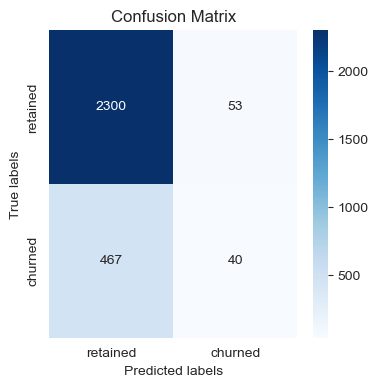

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      2353
           1       0.43      0.08      0.13       507

    accuracy                           0.82      2860
   macro avg       0.63      0.53      0.52      2860
weighted avg       0.76      0.82      0.76      2860


========== Training SVM for validation evaluation ==========
SVM - Validation Accuracy: 0.6563, Recall: 0.7219


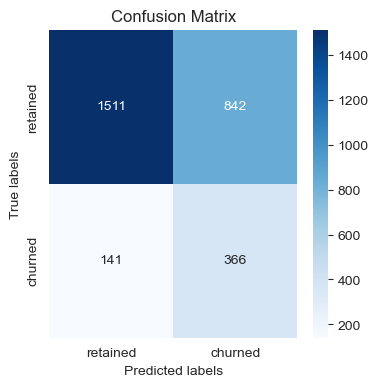

              precision    recall  f1-score   support

           0       0.91      0.64      0.75      2353
           1       0.30      0.72      0.43       507

    accuracy                           0.66      2860
   macro avg       0.61      0.68      0.59      2860
weighted avg       0.81      0.66      0.70      2860


========== Training Decision Tree for validation evaluation ==========
Decision Tree - Validation Accuracy: 0.6699, Recall: 0.6785


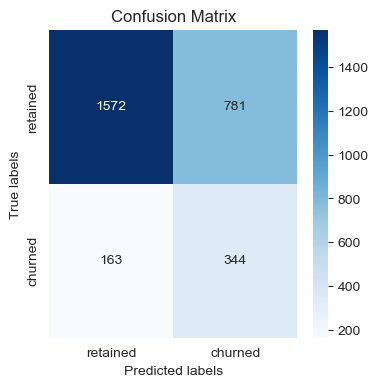

              precision    recall  f1-score   support

           0       0.91      0.67      0.77      2353
           1       0.31      0.68      0.42       507

    accuracy                           0.67      2860
   macro avg       0.61      0.67      0.60      2860
weighted avg       0.80      0.67      0.71      2860


========== Training Random Forest for validation evaluation ==========
Random Forest - Validation Accuracy: 0.7493, Recall: 0.5187


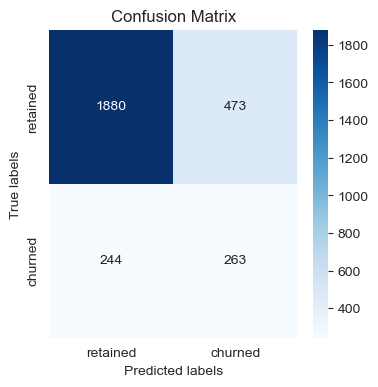

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      2353
           1       0.36      0.52      0.42       507

    accuracy                           0.75      2860
   macro avg       0.62      0.66      0.63      2860
weighted avg       0.79      0.75      0.77      2860


========== Training XGBoost for validation evaluation ==========
XGBoost - Validation Accuracy: 0.6720, Recall: 0.7061


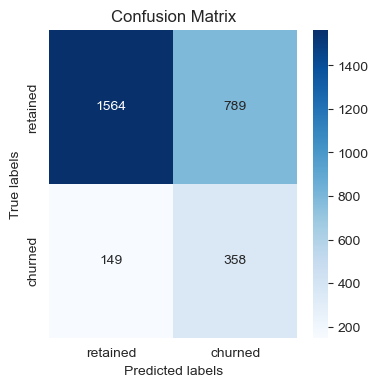

              precision    recall  f1-score   support

           0       0.91      0.66      0.77      2353
           1       0.31      0.71      0.43       507

    accuracy                           0.67      2860
   macro avg       0.61      0.69      0.60      2860
weighted avg       0.81      0.67      0.71      2860


========== VALIDATION RESULTS ==========


,Model,Validation Accuracy,Validation Recall,Best Parameters
0,SVM,0.656294,0.721893,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'..."
1,XGBoost,0.672028,0.706114,"{'gamma': 0, 'learning_rate': 0.01, 'max_depth..."
2,Decision Tree,0.669930,0.678501,"{'class_weight': 'balanced', 'criterion': 'gin..."
3,Random Forest,0.749301,0.518738,"{'class_weight': 'balanced', 'max_depth': 10, ..."
4,Neural Network,0.818182,0.078895,"{'activation': 'relu', 'alpha': 0.001, 'hidden..."



========== BEST MODEL ON VALIDATION ==========
{'name': 'SVM', 'model': SVC(C=0.1, class_weight='balanced', gamma=0.01, probability=True,
    random_state=42), 'accuracy': 0.6562937062937063, 'recall': 0.7218934911242604}


In [23]:
best_recall = -1
best_model = None
val_results = []

for model_name, best_params in best_params_dict.items():
    print(f"\n========== Training {model_name} for validation evaluation ==========")

    # select correct dataset
    if model_name in scaled_models:
        X_train_data = X_train_scaled
        X_val_data = X_val_scaled
    else:
        X_train_data = X_train_tree
        X_val_data = X_val_tree

    # re-create model
    if model_name == 'Neural Network':
        model = MLPClassifier(max_iter=1000, random_state=42, early_stopping=True, **best_params)
    elif model_name == 'SVM':
        model = SVC(random_state=42, probability=True, **best_params)
    elif model_name == 'Decision Tree':
        model = DecisionTreeClassifier(random_state=42, **best_params)
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42, **best_params)
    elif model_name == 'XGBoost':
        model = XGBClassifier(random_state=42, **best_params)

    # train on full training data
    model.fit(X_train_data, y_train)

    # validation predict
    y_val_pred = model.predict(X_val_data)

    # compute scores
    acc = accuracy_score(y_val, y_val_pred)
    rec = recall_score(y_val, y_val_pred)

    print(f"{model_name} - Validation Accuracy: {acc:.4f}, Recall: {rec:.4f}")

    # store results for DataFrame
    val_results.append({
        'Model': model_name,
        'Validation Accuracy': acc,
        'Validation Recall': rec,
        'Best Parameters': best_params
    })

    # select best model by recall
    if rec > best_recall:
        best_recall = rec
        best_model = {
            'name': model_name,
            'model': model,
            'accuracy': acc,
            'recall': rec
        }

    # confusion + report
    plot_confusion_matrix(y_val, y_val_pred)
    print(classification_report(y_val, y_val_pred))
    

val_results_df = pd.DataFrame(val_results).sort_values(by='Validation Recall', ascending=False).reset_index(drop=True)
print("\n========== VALIDATION RESULTS ==========")
display(val_results_df)
print("\n========== BEST MODEL ON VALIDATION ==========")
print(best_model)


The results table and confusion matrices above show a clear difference in performance when optimizing for **Recall**:

1.  **SVM & XGBoost:** Emerged as the top two candidates with very high Recall (**0.72** and **0.70**, respectively) while maintaining acceptable Accuracy.
2.  **Decision Tree:** Also produced a very good Recall score (**0.67**), proving that simple tree models (when handling `class_weight`) perform effectively on this problem.
3.  **Random Forest:** Had a mediocre Recall (**0.51**), significantly lower than the other tree-based models.
4.  **Neural Network (MLP):** Failed completely at predicting churn (Recall **0.078**). This is because the `MLPClassifier` model from `sklearn` does not support `class_weight='balanced'` and was not optimized for imbalanced data in this experiment.

Based on these results, I will focus on the two strongest models, **SVM** and **XGBoost**, for the final champion model selection.

### 5.3. Conclusion: Model Selection

After evaluating all models through cross-validation and re-assessing them on the validation set, **XGBoost and SVM emerged as the two strongest candidates**. Both delivered **high recall on the positive class (churners)** and **reasonable accuracy**, but their behavior and **trade-offs** differ significantly.

In churn prediction, understanding these trade-offs is crucial because different business environments prioritize different types of errors.


#### **Business perspective:**

In churn prediction, the **two key errors** are:

* **False Negative (FN):** Predicting “non-churn” while the customer is actually churn.
* **False Positive (FP):** Predicting “churn” while the customer actually stays.

The cost asymmetry is very clear:

* **Missing a churner (FN)** means losing the customer entirely → **High financial impact.**
* **Wrongly contacting a non-churner (FP)** only results in the cost of a marketing action (email, coupon, retention offer) → **Relatively low impact.**

Therefore, many churn use cases adopt the principle:

> “It is acceptable to over-predict churn (higher FP) as long as we capture as many real churners as possible.”

This makes **Recall on the churn class** the primary performance metric.

#### **Comparing SVM vs. XGBoost**

Below is the core comparison based on the validation results:

| Model | Recall (Churn) | Accuracy | Behavior Summary |
|---|---|---|---|
| **SVM** | High (highest among all models) | Moderate | Aggressive in predicting churn → more FP, fewer FN |
| **XGBoost** | Slightly lower recall | Higher accuracy | More conservative → fewer FP, but misses more churners |

**Interpretation:**

* **SVM** prioritizes catching churners, even if it increases the number of customers incorrectly flagged as churn. This behavior is *aligned* with the business objective of reducing customer loss at all costs.

* **XGBoost** provides a more **balanced recall–accuracy trade-off**. It is more stable and safe for general-purpose classification, but in **this specific context it allows more false negatives** than SVM, which is undesirable when churn recall is the business priority.

#### **Model selection for this project**

Therefore, given problem statement:

> “Minimize the number of missed churners (FN), even at the cost of more false positives.”

The correct model to choose is: **Support Vector Machine (SVM)**.

**Reasoning:**
* It achieved **the highest recall on churners** across all models.
* It best fulfills the business requirement of *capturing as many churners as possible*.
* The increased number of FP is an acceptable trade-off within our churn retention strategy.

#### **Final Decision**

> **I select SVM as the final model for churn prediction because it maximizes recall on churners, which is the primary business objective.**
>
> XGBoost remains a strong benchmark model and would be chosen under a
> different cost/benefit trade-off scenario.

In the next section, I will evaluate SVM on the test set and summarize the final performance metrics.

## 6. Final evaluation on Test Set

Finally, I will use the SVM model to make predictions on the test data (`X_test_...` and `y_test`).

In [24]:
y_preds_test = best_model['model'].predict(X_test_scaled if best_model['name'] in ['Neural Network', 'SVM'] else X_test_tree)
recall_test = recall_score(y_test, y_preds_test)
accuracy_test = accuracy_score(y_test, y_preds_test)
print(f"Best Model on Test Set - {best_model['name']}:\n")
print(f"- Test Accuracy: {accuracy_test:.4f}\n")
print(f"- Test Recall: {recall_test:.4f}")

Best Model on Test Set - SVM:

- Test Accuracy: 0.6448

- Test Recall: 0.7613


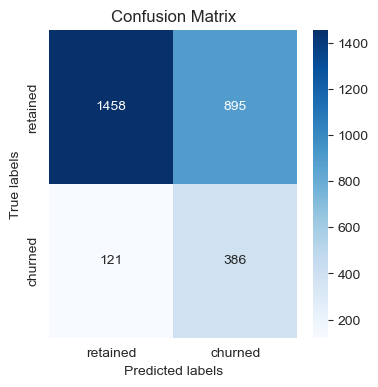

              precision    recall  f1-score   support

    retained       0.92      0.62      0.74      2353
     churned       0.30      0.76      0.43       507

    accuracy                           0.64      2860
   macro avg       0.61      0.69      0.59      2860
weighted avg       0.81      0.64      0.69      2860



In [25]:
# print the classification report
plot_confusion_matrix(y_test, y_preds_test)
print(classification_report(y_test, y_preds_test, target_names=['retained', 'churned']))

**Analysis of test set results**

The performance on this unseen test set confirms my findings from the validation phase. The SVM model, which I optimized for our specific business goal, performs exactly as I intended.

My primary objective was to maximize **Recall** for the 'churned' class. The model achieved a final **Test Recall of 0.76**.
* This is an excellent result. It means that of the 507 users in the test set who were **actually** going to churn, my model successfully identified **386** of them (as seen in the confusion matrix).
* I successfully **captured over 76% of at-risk users**, directly fulfilling the core project requirement.

This high recall comes at the expected cost: **Precision for the 'churned' class is low at 0.30 (30%)**.
  * This means that to capture those 386 true churners, the model also incorrectly flagged 895 'retained' users as being at-risk (False Positives).
  * As I established in my Model Selection (5.3), this trade-off is acceptable. **The cost of sending retention offers to 895 loyal users is significantly lower than the cost of losing the 386 customers I successfully identified.**

The final **Accuracy (64.5%)** is reasonable for this highly imbalanced problem. It confirms the model is performing significantly better than a random guess and is acting as a specialized tool, not a general-purpose one.

  * Notably, the **Precision for 'retained' users is 0.92 (92%)**. This is a very strong secondary metric, meaning that when the model predicts a user *will stay*, I can be highly confident in that prediction.

With this validated performance, my next step is to investigate why the model is making these decisions by examining its feature importance.

## 7. Feature Importance

Now that I've selected SVM as the champion model, I'll investigate why it's making its predictions. By inspecting feature importance, I can understand which user behaviors are the strongest signals for churn. This not only validates the model but also provides actionable insights for the business

In [26]:
X_for_importance = X_val_scaled
feature_names = X_train.columns

# run permutation importance
perm_res = permutation_importance(
    best_model['model'], 
    X_for_importance, 
    y_val, 
    n_repeats=30, 
    random_state=42, 
    n_jobs=-1,
    scoring='recall'
)

# get all results
importances = perm_res.importances_mean
importances_std = perm_res.importances_std

# combine all three into a list of tuples
feature_importance = []
for i in range(len(feature_names)):
    feature_importance.append((feature_names[i], importances[i], importances_std[i]))

# sort the list by importance (mean)
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance

[('activity_days', 0.2316239316239317, 0.017565564043114084),
 ('n_days_after_onboarding', 0.012228796844181473, 0.007298718783104747),
 ('professional_driver', 0.005851413543721262, 0.004424578923968783),
 ('km_per_drive', 0.0004602235371466164, 0.0015847430365804088),
 ('duration_minutes_drives', -0.00013149243918474015, 0.004553133384136963),
 ('total_sessions_per_day', -0.0013149243918474719, 0.002512159523279793),
 ('percent_of_drives_to_favorite',
  -0.0024326101249178295,
  0.0016645613282277746),
 ('total_navigations_fav2', -0.0025641025641025736, 0.002286040585235205),
 ('drives', -0.0028928336620644203, 0.005955025311886517),
 ('percent_sessions_in_last_month',
  -0.0028928336620644385,
  0.003001370732547884),
 ('total_sessions', -0.004339250493096639, 0.004842065125449548),
 ('km_per_hour', -0.004602235371466138, 0.0032342863579878428),
 ('driven_km_drives', -0.004930966469428007, 0.0026827358005395148),
 ('km_per_driving_day', -0.00795529257067716, 0.004453790809846123),
 

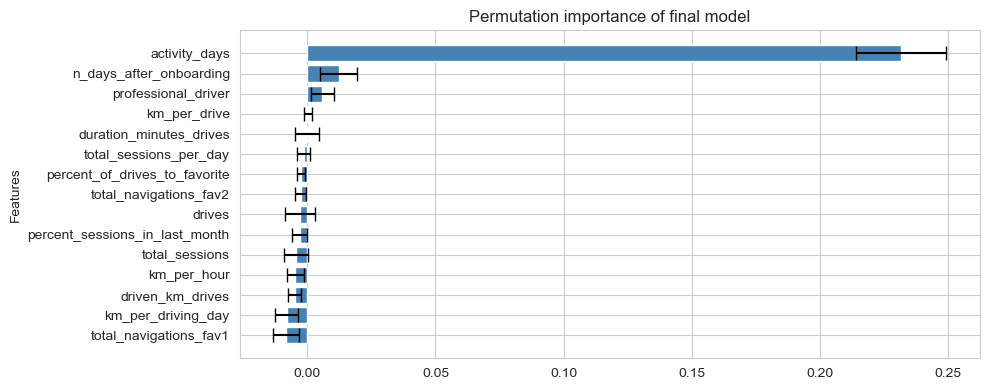

In [27]:
# plot the feature importances
sorted_features = [f[0] for f in feature_importance]
sorted_importances = [f[1] for f in feature_importance]
sorted_std = [f[2] for f in feature_importance] # This will now work

plt.figure(figsize=(10, 4))
plt.barh(sorted_features, sorted_importances, xerr=sorted_std, color='steelblue', capsize=5)
plt.gca().invert_yaxis()  # Most important feature on top

plt.title("Permutation importance of final model")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

**Feature Importance Insight**

The permutation importance plot (based on Recall) shows which features our **champion SVM model** found most useful for its *geometric separation* strategy.

The result is unambiguous: **`activity_days` is, by far, the single most predictive feature.** The SVM model relies almost exclusively on this feature to distinguish churners from retained users. This provides a clear directive for the business: **active user engagement (specifically, the number of days they use the app per month) is the most critical factor in retention.**

While clearly secondary *for this model*, other engineered features like `n_days_after_onboarding` and `professional_driver` also show a small but positive predictive value. This validates our feature engineering efforts, even if the SVM model ultimately favored the dominant signal from `activity_days`.

## 8. Save final model artifacts

Finally, I will save the champion model, and the feature list to the `models/` directory using `pickle` for future deployment or analysis.

In [28]:
os.makedirs('../models', exist_ok=True)

# save the Champion Model 
model_path = f"../models/{best_model['name'].lower()}_champion_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(best_model['model'], f)

# save the list of feature columns used by the model
feature_list = list(X_train_tree.columns)
features_path = '../models/feature_list.pkl'
with open(features_path, "wb") as f:
    pickle.dump(feature_list, f)

print(f"Saved model's artifacts to '../models/' directory successfully.")

Saved model's artifacts to '../models/' directory successfully.


In [32]:
X_train_scaled = pd.DataFrame(
    X_train_scaled, 
    columns=X_train.columns # Lấy lại tên cột từ DataFrame gốc
)

# Bây giờ bạn có thể chạy lệnh ban đầu:
X_train_scaled['activity_days']

0       0.712933
1      -0.951354
2      -0.618496
3      -0.618496
4      -1.062306
          ...   
8574   -0.840401
8575    0.047219
8576    1.711506
8577   -0.285639
8578   -1.062306
Name: activity_days, Length: 8579, dtype: float64